In [3]:
!pip install --upgrade pip
!pip install xgboost imbalanced-learn


  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\bbuser\anaconda3\python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.1 MB 5.0 MB/s eta 0:00:02
   ---------- ----------------------------- 2.9/11.1 MB 9.9 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.1 MB 11.6 MB/s eta 0:00:01
   ------------------------------------ --- 10.2/11.1 MB 12.5 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0


  You can safely remove it manually.


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

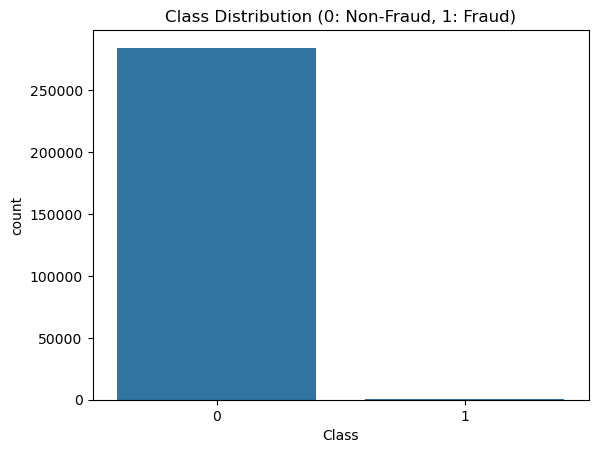

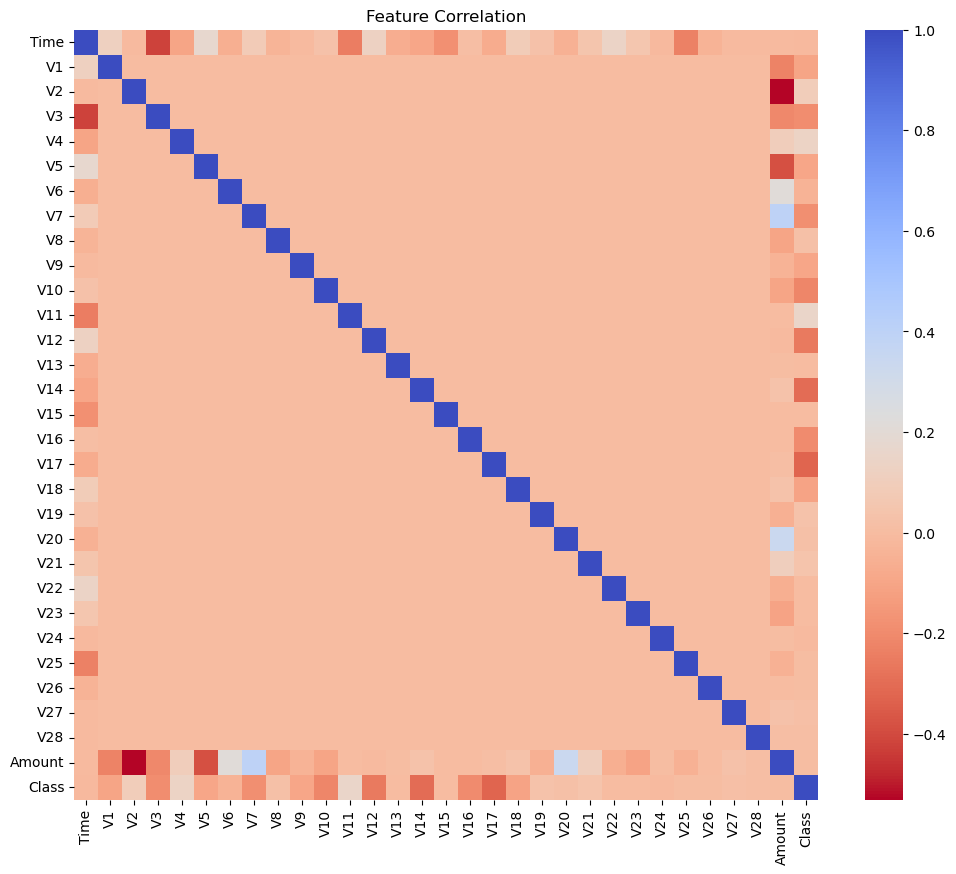

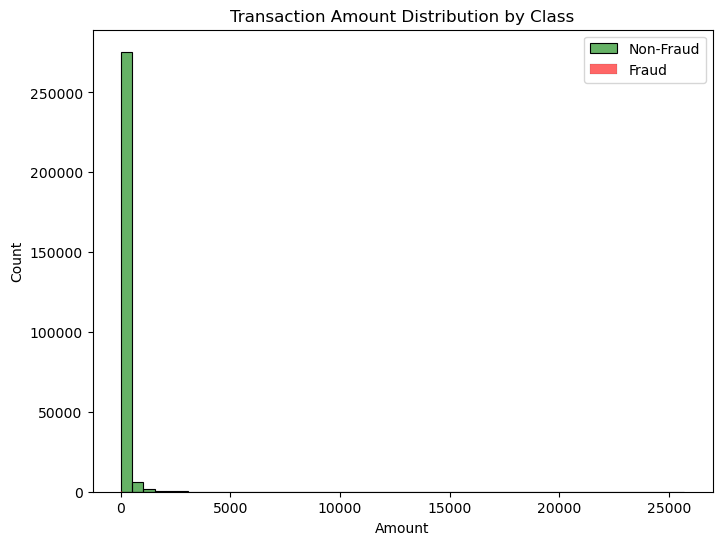


LogisticRegression Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.61      0.72       148

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

LogisticRegression ROC-AUC Score: 0.9560

DecisionTree Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.74      0.76       148

    accuracy                           1.00     85443
   macro avg       0.89      0.87      0.88     85443
weighted avg       1.00      1.00      1.00     85443

DecisionTree ROC-AUC Score: 0.8681

RandomForest Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.76      0.

In [ ]:
# Step 0: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Step 1: Load dataset and EDA
df = pd.read_csv('creditcard.csv')  # Replace with your dataset path

# Quick overview
print(df.head())
print(df.shape)
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Check class imbalance
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm_r', annot=False)
plt.title('Feature Correlation')
plt.show()

# Distribution of 'Amount' by Class
plt.figure(figsize=(8,6))
sns.histplot(df[df['Class']==0]['Amount'], color='green', bins=50, label='Non-Fraud', alpha=0.6)
sns.histplot(df[df['Class']==1]['Amount'], color='red', bins=50, label='Fraud', alpha=0.6)
plt.legend()
plt.title('Transaction Amount Distribution by Class')
plt.show()

# Step 2: Data Preprocessing
X = df.drop('Class', axis=1)
y = df['Class']

# Scale 'Amount' and 'Time' features
scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 3: Baseline Models
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

baseline_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"{name} ROC-AUC Score: {roc_auc:.4f}")
    
    baseline_results[name] = {'model': model, 'roc_auc': roc_auc}

# Step 4: ROC Curves
plt.figure(figsize=(8,6))
for name, result in baseline_results.items():
    model = result['model']
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, y_prob):.4f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Step 5: Model Improvement with SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

improved_results = {}
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    print(f"\n{name} (SMOTE) Classification Report:\n")
    print(classification_report(y_test, y_pred))
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    print(f"{name} PR-AUC Score: {pr_auc:.4f}")
    
    improved_results[name] = {'model': model, 'pr_auc': pr_auc}

# Optional: Adjust decision threshold
best_model = improved_results['XGBoost']['model']
y_prob = best_model.predict_proba(X_test)[:,1]
threshold = 0.3  # Example: lower threshold to catch more frauds
y_pred_adj = (y_prob >= threshold).astype(int)
print("\nXGBoost Adjusted Threshold Classification Report:")
print(classification_report(y_test, y_pred_adj))

# Step 6: Summary
print("\nSummary:")
for name, result in improved_results.items():
    print(f"{name} PR-AUC: {result['pr_auc']:.4f}")
